# Машинное обучение 1, ПМИ ФКН ВШЭ
# Семинар 8
# Cross-Entropy, Batch Norm, CNN, ResNet, заморозка весов и дообучение

### Imports

In [1]:
# !pip install torchvision==0.15.2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

import math
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [4]:
torch.manual_seed(1337)
random.seed(1337)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:0


## Cross-Entropy

### Бинарная классификация

Пойдем по определению [Бишопа](https://scholar.google.com/citations?user=gsr-K3ADUvAC&hl=en)

Рассмотрим бинарную классификацию с целевой переменной $t\in\{0,1\}$, где $t=1$ – класс $C_1$, а $t=0$  класс $C_2$.

Пусть нейросеть имеет один выход с логистической сигмоидой, так что $0\le y(\mathbf{x},\mathbf{w})\le 1$.

Интерпретируем $y(\mathbf{x},\mathbf{w})$ как $p(C_1\mid \mathbf{x})$, тогда $p(C_2\mid \mathbf{x})=1-y(\mathbf{x},\mathbf{w})$.

**Условное распределение Бернулли:**
$$
p(t\mid \mathbf{x},\mathbf{w})=y(\mathbf{x},\mathbf{w})^{\,t}\,[1-y(\mathbf{x},\mathbf{w})]^{\,1-t}.
$$

Для обучающего набора из независимых наблюдений функция ошибки – это negative log likelihood (кросс-энтропия):
$$
E(\mathbf{w})=-\sum_{n=1}^{N}\Big[t_n\ln y_n+(1-t_n)\ln(1-y_n)\Big],
$$
где $y_n \equiv y(\mathbf{x}_n,\mathbf{w})$.

> На практике использование кросс-энтропии вместо суммы квадратов часто ускоряет обучение и улучшает обобщение (Simard, Steinkraus, Platt, 2003).

Давайте просуммируем все ранее

Кросс-энтропия — это **честная шкала качества** для вероятностей модели.

**Логика:**
- Модель не говорит просто «0/1», она даёт **вероятность** правильного класса
- Если на верный класс ставишь высокую вероятность — хорошо; если **уверенно не туда**, то штрафуем сильно
- **Штраф для одного примера:**
  $$
  -\big[t\log y + (1-t)\log(1-y)\big].
  $$
  Здесь $y$ – предсказанная вероятность «класс = 1», а $t\in\{0,1\}$ – истинный лейбл.

**Обучение:**
- Суммируем по датасету и **минимизируем**:
  $$
  E(\mathbf{w}) \;=\; -\sum_{n=1}^{N}\Big[t_n\log y_n + (1-t_n)\log(1-y_n)\Big],
  $$
  где $y_n = y(\mathbf{x}_n,\mathbf{w})$.

Давайте напишем код кросс-энтропии

In [6]:
def binary_cross_entropy(y_pred, y_true, epsilon=1e-7):
    """
    
    E = -1/N * Σ[t*ln(y) + (1-t)*ln(1-y)], t – это y_true
    """
    
    # Защита от log(0)
    y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon) ### Your CODE:
    
    # Формула Бишопа 
    loss = -(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)) ### Your CODE:
    
    return loss.mean()

In [13]:
z = torch.tensor([[-1.0, 0.2, 2.5],
                   [ 0.0, -4.0, 1.0]])
p = torch.sigmoid(z)          
y = torch.tensor([[0., 1., 1.],
                   [0., 0., 1.]])

loss_ours = binary_cross_entropy(p, y)
loss_ref  = F.binary_cross_entropy(p, y, reduction="mean")

In [15]:
print("loss_ours", loss_ours)
print("loss_ref", loss_ref)

loss_ours tensor(0.3358)
loss_ref tensor(0.3358)




### Независимые бинарные задачи (K выходов)

Если нужно провести $K$ **отдельных** бинарных классификаций, то используем нейросеть с $K$ выходами, каждый с сигмоидой.  
Пусть лейбл класса $k$: $t_k\in\{0,1\}$, $k=1,\dots,K$.  
При предположении независимости меток условное распределение:
$$
p(\mathbf{t}\mid \mathbf{x},\mathbf{w})
=\prod_{k=1}^{K} y_k(\mathbf{x},\mathbf{w})^{\,t_k}\,[1-y_k(\mathbf{x},\mathbf{w})]^{\,1-t_k}.
$$

**Отрицательное лог-правдоподобие (кросс-энтропия):**
$$
E(\mathbf{w})
=-\sum_{n=1}^{N}\sum_{k=1}^{K}
\Big[t_{nk}\ln y_{nk}+(1-t_{nk})\ln(1-y_{nk})\Big],
$$
где $y_{nk}\equiv y_k(\mathbf{x}_n,\mathbf{w})$.

> Производные этой функции ошибки по предварительным активациям конкретного выхода имеют стандартный вид (как в случае регрессии): градиент пропорционален $y - t$, что обеспечивает простой и стабильный сигнал обучения.


## Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift

Так называется оригинальная [статья](https://arxiv.org/abs/1502.03167), с чего все началось.

**Batch Normalization (BatchNorm)** – это один из ключевых методов стабилизации и ускорения обучения нейронных сетей. **BatchNorm** нужен для борьбы с проблемой *внутреннего ковариационного сдвига* (internal covariate shift), когда распределение входов в каждый слой сети сильно меняется по мере обновления весов, что замедляет обучение.  

Если говорить по-простому, когда мы обучаем нейросеть, у неё на каждом слое появляются какие-то "промежуточные данные" – активации. Проблема в том, что эти данные постоянно "плывут": после каждой итерации обучения распределение значений на входе слоя меняется, потому что обновились веса предыдущих слоёв. Это и называют внутренним ковариационным сдвигом.

### Формулки

Пусть у нас есть входные данные $x_1, x_2, \dots, x_m$ в батче размером $m$.  
Процесс нормализации выглядит так:  

1. Считаем среднее по батчу:

    $$
    \mu_B = \frac{1}{m} \sum_{i=1}^m x_i
    $$

2. Считаем дисперсию (разброс значений):

    $$
    \sigma_B^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2
    $$

3. Нормализуем каждое значение (приводим к нулевому среднему и единичной дисперсии):

    $$
    \hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
    $$

где $\epsilon$ — очень маленькая константа, которая нужна для численной стабильности (чтобы не делить на ноль).

4. Добавляем обучаемые параметры (масштаб $\gamma$ и сдвиг $\beta$):

    $$
    y_i = \gamma \hat{x}_i + \beta
    $$


> P.S. Очень любят спрашивать на собеседованиях.

### Как работает BatchNorm в `train()` и `eval()` в PyTorch

**В режиме `model.train()`**
- Нормируем **по статистикам текущего мини-батча**:
  
  $
  y = \gamma \cdot \frac{x - \mu_B}{\sqrt{\sigma_B^2 + \varepsilon}} + \beta
  $

  где $\mu_B$, $\sigma_B^2$ – среднее и дисперсия по батчу
  (для Conv — считаются по осям \(N,H,W\) для каждого канала, но это позже).

- **Накопление (running) статистик** — экспоненциальное сглаживание:
  
  $
  \text{running\_mean} \leftarrow (1-m)\,\text{running\_mean} + m\,\mu_B
  $
  
  $
  \text{running\_var} \leftarrow (1-m)\,\text{running\_var} + m\,\sigma_B^2
  $
  
  где `momentum = m` (по умолчанию 0.1).  
  Если `momentum=None`, используется кумулятивное среднее (по счётчику `num_batches_tracked`).

---

**В режиме `model.eval()`**
- Статистики **не обновляются**.
- Нормирование идёт по **накопленным** оценкам:
  
  $
  y = \gamma \cdot \frac{x - \text{running\_mean}}{\sqrt{\text{running\_var} + \varepsilon}} + \beta
  $
  
  Это делает инференс стабильным и независимым от состава текущего батча.

---

#### Что значит «накапливать статистики»?
Хранить в буферах `running_mean` и `running_var` сглажённые оценки средних и дисперсий признаков (по каналам).  
Они приближают «популяционные» значения и используются в `eval()` вместо шумных батч-оценок.

---

#### Полезные нюансы
- `track_running_stats=False` → BN **всегда** использует батч-статы и не хранит running-буферы (даже в `eval()`), вывод зависит от размера/состава батча.
- `affine=False` отключает обучаемые $\gamma$, $\beta$.
- Очень маленькие батчи → неточные статы: рассмотрите **LayerNorm/GroupNorm/InstanceNorm**.
- `torch.no_grad()` **не переключает** BN в `eval()` — нужен явный вызов `model.eval()`.

> Тоже любят очень спрашивать на собесах

### Давайте реализуем с помощью PyTorch наш BatchNorm

In [5]:
# Дано:

x = torch.tensor([
    [0.4963, 0.7682, 0.0885],
    [0.1320, 0.3074, -0.6343],
    [0.4901, -0.1123, -0.1152],
    [-0.2814, 0.1494, -0.2310]
])

## Какой тут размер m?

#### Шаг 1. Посчитайте среднее по батчу

In [6]:
mu_B = x.mean(dim=0, keepdim=True) # YOUR CODE HERE
print("\nСреднее (mu_B):\n", mu_B)


Среднее (mu_B):
 tensor([[ 0.2093,  0.2782, -0.2230]])


#### Шаг 2. Посчитайте дисперсию

In [7]:
var_B = x.var(dim=0, unbiased=False, keepdim=True) # YOUR CODE HERE
print("\nДисперсия (sigma_B^2):\n", var_B)


Дисперсия (sigma_B^2):
 tensor([[0.1020, 0.1025, 0.0695]])


#### Шаг 3. Нормализуем каждое значение

In [8]:
eps = 1e-5
x_hat = (x - mu_B) / torch.sqrt(var_B + eps) # YOUR CODE HERE
print("\nНормализованные значения (x_hat):\n", x_hat)


Нормализованные значения (x_hat):
 tensor([[ 0.8988,  1.5304,  1.1817],
        [-0.2419,  0.0913, -1.5604],
        [ 0.8794, -1.2195,  0.4090],
        [-1.5362, -0.4022, -0.0303]])


#### Шаг 4. Добавляем масштаб и сдвиг

In [9]:
gamma = torch.ones(1, 3)   # масштаб
beta = torch.zeros(1, 3)   # сдвиг

y = gamma * x_hat + beta
print("\nВыход после BatchNorm (y):\n", y)


Выход после BatchNorm (y):
 tensor([[ 0.8988,  1.5304,  1.1817],
        [-0.2419,  0.0913, -1.5604],
        [ 0.8794, -1.2195,  0.4090],
        [-1.5362, -0.4022, -0.0303]])


#### Давайте сравним с реализацией из PyTorch

In [10]:
bn = torch.nn.BatchNorm1d(num_features=3, affine=True, track_running_stats=False)

with torch.no_grad():
    bn.weight.copy_(gamma.squeeze())
    bn.bias.copy_(beta.squeeze())

y_bn = bn(x)
print("\nPyTorch nn.BatchNorm1d:\n", y_bn)



PyTorch nn.BatchNorm1d:
 tensor([[ 0.8988,  1.5304,  1.1817],
        [-0.2419,  0.0913, -1.5604],
        [ 0.8794, -1.2195,  0.4090],
        [-1.5362, -0.4022, -0.0303]], grad_fn=<NativeBatchNormBackward0>)


In [11]:
torch.allclose(y_bn, y, atol=1e-6)

True

### Затухание градиента, что это и как это?

Ситуация, когда при backprop градиенты экспоненциально уменьшаются на ранних слоях и обучение «стоит», лосс плато.

Как ни странно, но не только dropout, инициализация и другие активации помогают, но и **нормализация**.

Давайте рассмотрим пример затухания градиента на синтетическом примере:

In [ ]:
N = 2048          # объектов
D_in = 64         # признаков
D_hidden = 128
D_out = 1

In [ ]:
X = torch.randn(N, D_in)
w_true = torch.randn(D_in, D_out)
y = X @ w_true + 0.1 * torch.randn(N, D_out)

In [ ]:
batch_size = 128
dataset = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class ClassicMLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, depth=20, use_bn=False):
        super().__init__()
        layers = []
        layers.append(nn.Linear(d_in, d_hidden))
        if use_bn: layers.append(nn.BatchNorm1d(d_hidden))
        layers.append(nn.ReLU(inplace=False))

        for _ in range(depth - 2):
            layers.append(nn.Linear(d_hidden, d_hidden))
            if use_bn: layers.append(nn.BatchNorm1d(d_hidden))
            layers.append(nn.ReLU(inplace=False))

        layers.append(nn.Linear(d_hidden, d_out))
        self.net = nn.Sequential(*layers)


    def forward(self, x):
        return self.net(x)

In [ ]:
def train_model(model, optimizer, train_loader, loss_fn=nn.MSELoss(), epochs=200, label="no_bn"):

    grad_norms, losses = [], []

    pbar = tqdm(range(epochs), desc=f"[{label}] training", unit="epoch")
    for epoch in pbar:
        epoch_losses = []
        epoch_grad_norms = []

        for x_train, y_train in train_loader:
            x_train, y_train = x_train.to(device), y_train.to(device)

            optimizer.zero_grad()

            pred = model(x_train)
            loss = loss_fn(pred, y_train)

            loss.backward()

            # Вычисляем 2-норму градиента
            total_sq = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    total_sq += p.grad.detach().pow(2).sum().item()
            grad_norm = math.sqrt(total_sq)

            # Проверяем на взрыв градиентов
            if (not math.isfinite(grad_norm)) or (not math.isfinite(loss.item())):
                print(f"[{label}] epoch {epoch}, batch: grad_norm={grad_norm}, loss={loss.item()} → остановка (взрыв).")
                # Показать то, что успели накопить
                if len(losses) > 0 or len(grad_norms) > 0:
                    clear_output(wait=True)
                    fig = plt.figure(figsize=(10, 4))
                    plt.subplot(1, 2, 1)
                    plt.plot(grad_norms, '-o', markersize=3)
                    plt.title('grad_norm')
                    plt.xlabel('epoch'); plt.ylabel('||grad||₂')

                    plt.subplot(1, 2, 2)
                    plt.plot(losses, '-o', markersize=3)
                    plt.title('loss')
                    plt.xlabel('epoch'); plt.ylabel('loss')
                    plt.tight_layout()
                    display(fig)
                return grad_norms, losses

            epoch_losses.append(loss.item())
            epoch_grad_norms.append(grad_norm)

            # Обновляем веса
            optimizer.step()

        # Сохраняем средние значения за эпоху
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        avg_grad_norm = sum(epoch_grad_norms) / len(epoch_grad_norms)

        losses.append(avg_loss)
        grad_norms.append(avg_grad_norm)

        # Обновляем прогресс-бар
        pbar.set_postfix(loss=f"{avg_loss:.4f}", grad_norm=f"{avg_grad_norm:.2e}")

        # Лог и графики каждые 10 эпох
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            print(f"[{label}] epoch {epoch+1:3d}: loss={avg_loss:.4f}, grad_norm={avg_grad_norm:.2e}")
            fig = plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.plot(grad_norms, '-o', markersize=3)
            plt.title('grad_norm')
            plt.xlabel('epoch'); plt.ylabel('||grad||₂')

            plt.subplot(1, 2, 2)
            plt.plot(losses, '-o', markersize=3)
            plt.title('loss')
            plt.xlabel('epoch'); plt.ylabel('loss')
            plt.tight_layout()
            # display(fig)

    return grad_norms, losses

In [ ]:
depth = 20
lr = 1e-2        # высокий LR — преднамеренно
epochs = 100

model_no_batch_norm = ClassicMLP(D_in, D_hidden, D_out, depth=depth, use_bn=False)
model_no_batch_norm = model_no_batch_norm.to(device)
optimizer_no_batch_norm = torch.optim.SGD(model_no_batch_norm.parameters(), lr=lr)  # завышаем LR для провокации взрыва


gn_no_bn, loss_no_bn = train_model(model_no_batch_norm, optimizer_no_batch_norm, train_loader, epochs=epochs, label="no_batch_norm")

In [ ]:
depth = 20
lr = 1e-2
epochs = 100

model_with_batch_norm = ClassicMLP(D_in, D_hidden, D_out, depth=depth, use_bn=True)
model_with_batch_norm = model_with_batch_norm.to(device)
optimizer_with_batch_norm = torch.optim.SGD(model_with_batch_norm.parameters(), lr=lr)  # завышаем LR для провокации взрыва


gn_with_bn, loss_with_bn = train_model(model_with_batch_norm, optimizer_with_batch_norm, train_loader, epochs=epochs, label="with_batch_norm")

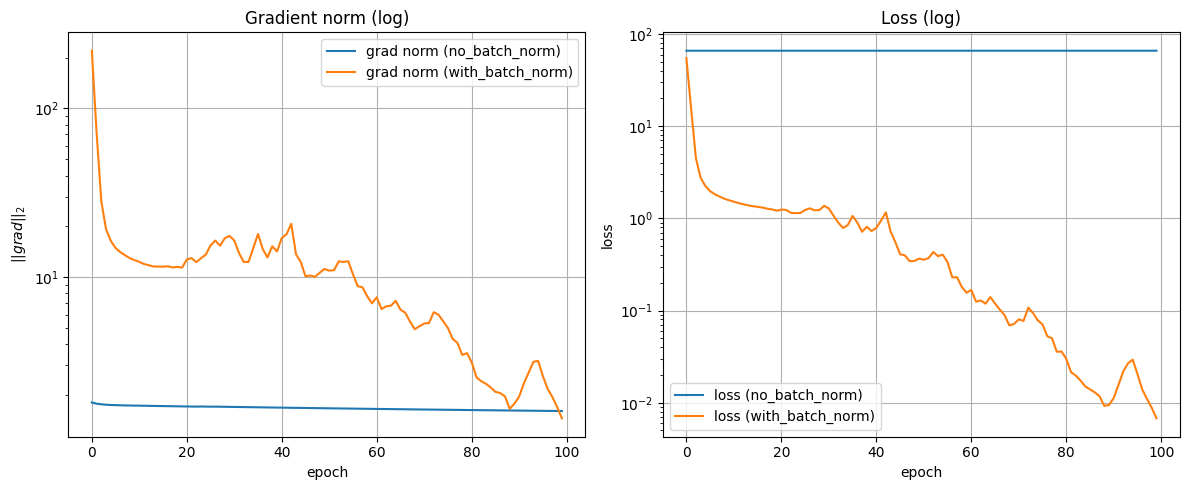

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gn_no_bn, label="grad norm (no_batch_norm)")
plt.plot(gn_with_bn, label="grad norm (with_batch_norm)")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("$||grad||_2$")
plt.title("Gradient norm (log)")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(loss_no_bn, label="loss (no_batch_norm)")
plt.plot(loss_with_bn, label="loss (with_batch_norm)")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss (log)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Тут вы можете заметить классический пример затухающего градиента (vanishing gradients)

#### Левый график

График без нормы – горизонтальный и очень низкий на всём протяжении – градиенты крошечные → шаги оптимизатора микроскопические → сеть фактически не учится.

График с нормой стартует с больших значений (десятки–сотни), затем быстро спадает и колеблется в разумном диапазоне, постепенно уменьшаясь. Это здоровая картина: градиенты достаточно большие, чтобы двигать веса, и по мере приближения к минимуму становятся меньше.

#### Правый график

График без нормы – плато на высоком уровне – подтверждение, что без BN модель застряла и градиенты затухли.

График с нормой падает на несколько порядков (до 1e-2) с небольшими «волнами» – обучение идёт, лосс снижается.

### Взрыв градиента

Взрыв градиента – это когда производные растут неконтролируемо, шаги оптимизатора огромные, лосс скачет, появляются NaN/Inf.

С чем связано: слишком большой learning rate, плохая инициализация, очень глубокие сети/RNN, отсутствие нормализации.

Контрмеры: уменьшить LR, gradient clipping, **нормализации!**, корректная инициализация, residual-связи, weight decay.

In [ ]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [ ]:
class DeepMLP(nn.Module):
    def __init__(self, in_dim=28*28, hidden=512, depth=12, use_bn=False):
        super().__init__()
        layers = []
        layers += [nn.Linear(in_dim, hidden)]
        if use_bn: layers += [nn.BatchNorm1d(hidden)]
        layers += [nn.Tanh()]   # tanh специально, чтобы без BN было тяжелее

        for _ in range(depth - 2):
            layers += [nn.Linear(hidden, hidden)]
            if use_bn: layers += [nn.BatchNorm1d(hidden)]
            layers += [nn.Tanh()]

        layers += [nn.Linear(hidden, 10)]  # logits для CrossEntropy
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

def grad_norm(model):
    total_sq = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_sq += p.grad.detach().pow(2).sum().item()
    return math.sqrt(total_sq) if total_sq > 0 else 0.0

def evaluate(model, test_loader, loss_fn=nn.CrossEntropyLoss()):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss_sum += loss_fn(logits, y).item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    return loss_sum / total, correct / total


In [ ]:
def train_model(
    model,
    optimizer,
    train_loader,
    test_loader,
    loss_fn=nn.CrossEntropyLoss(),
    epochs=100,
    label="no_bn",
    plot_every_epochs=10,   # как часто перерисовывать графики
):
    model.to(device)
    gns, losses = [], []
    global_step = 0
    early_stop = False

    pbar = tqdm(range(epochs), desc=f"[{label}] training", unit="epoch")
    for epoch in pbar:
        model.train()
        for batch_idx, (x_train, y_train) in enumerate(train_loader):
            x_train, y_train = x_train.to(device), y_train.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x_train)
            loss = loss_fn(logits, y_train)
            loss.backward()

            # норма градиента
            total_sq = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    total_sq += p.grad.detach().pow(2).sum().item()
            gn = math.sqrt(total_sq) if total_sq > 0 else 0.0

            gns.append(gn)
            losses.append(loss.item())

            # ранний стоп при NaN/Inf
            if not (math.isfinite(gn) and math.isfinite(loss.item())):
                print(f"[{label}] epoch {epoch+1}, batch {batch_idx+1}: "
                      f"grad_norm={gn}, loss={loss.item()} → остановка (взрыв).")
                early_stop = True
                break

            optimizer.step()
            global_step += 1

            # обновляем прогресс-бар (показываем последние значения)
            pbar.set_postfix(loss=f"{loss.item():.4f}", grad_norm=f"{gn:.2e}")

        # тротлим отрисовку: раз в N эпох или при ранней остановке
        if ((epoch + 1) % plot_every_epochs == 0) or early_stop:
            clear_output(wait=True)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(gns, '-o', markersize=2)
            axes[0].set_title('grad_norm'); axes[0].set_xlabel('step'); axes[0].set_ylabel('||grad||₂')
            axes[1].plot(losses, '-o', markersize=2)
            axes[1].set_title('loss'); axes[1].set_xlabel('step'); axes[1].set_ylabel('loss')
            plt.tight_layout()
            display(fig)
            plt.close(fig)

        if early_stop:
            print(f"[{label}] early stop at epoch {epoch+1}, global_step {global_step}.")
            break

    test_loss, test_acc = evaluate(model, test_loader)
    print(f"[{label}] TEST  loss={test_loss:.4f}, acc={test_acc:.4f}")
    return gns, losses


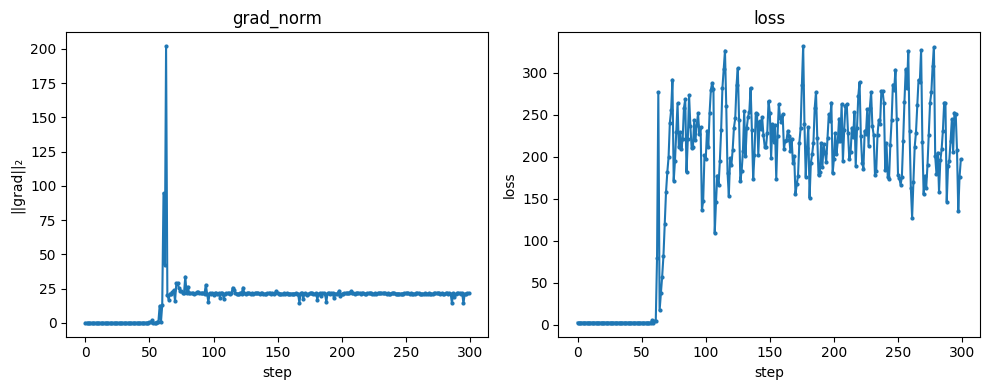

[NO_BN] training: 100%|██████████| 20/20 [02:17<00:00,  6.87s/epoch, grad_norm=2.16e+01, loss=196.9127]


[NO_BN] TEST  loss=236.3155, acc=0.1009


In [ ]:
depth = 12
lr = 1.0
epochs = 20

model_no_batch_norm = DeepMLP(depth=depth, use_bn=False)
model_no_batch_norm = model_no_batch_norm.to(device)
optimizer_no_batch_norm = torch.optim.SGD(model_no_batch_norm.parameters(), lr=lr)

gn_no_bn, loss_no_bn = train_model(model_no_batch_norm, optimizer_no_batch_norm, train_loader, test_loader, epochs=epochs, label="NO_BN")


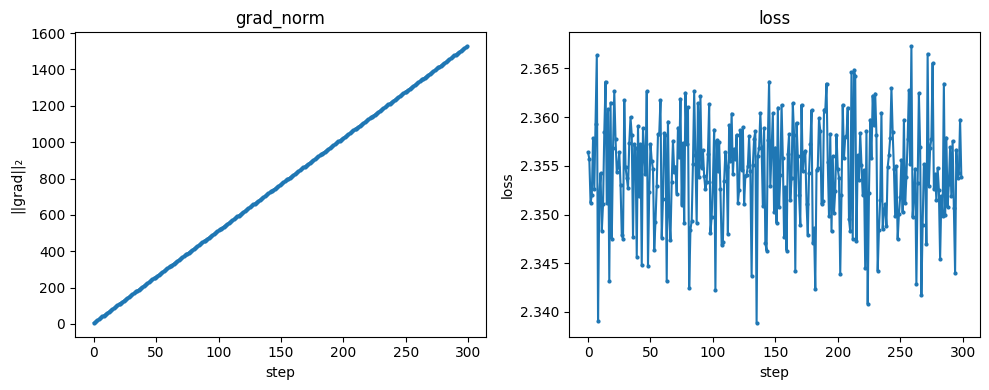

[WITH_BN] training: 100%|██████████| 20/20 [02:28<00:00,  7.42s/epoch, grad_norm=1.53e+03, loss=2.3539]


[WITH_BN] TEST  loss=2.3625, acc=0.0914


In [ ]:
model_with_batch_norm = DeepMLP(depth=depth, use_bn=True)
model_with_batch_norm = model_with_batch_norm.to(device)
optimizer_with_batch_norm = torch.optim.SGD(model_no_batch_norm.parameters(), lr=lr)

gn_with_bn, loss_with_bn = train_model(model_with_batch_norm, optimizer_with_batch_norm, train_loader, test_loader, epochs=epochs, label="WITH_BN")

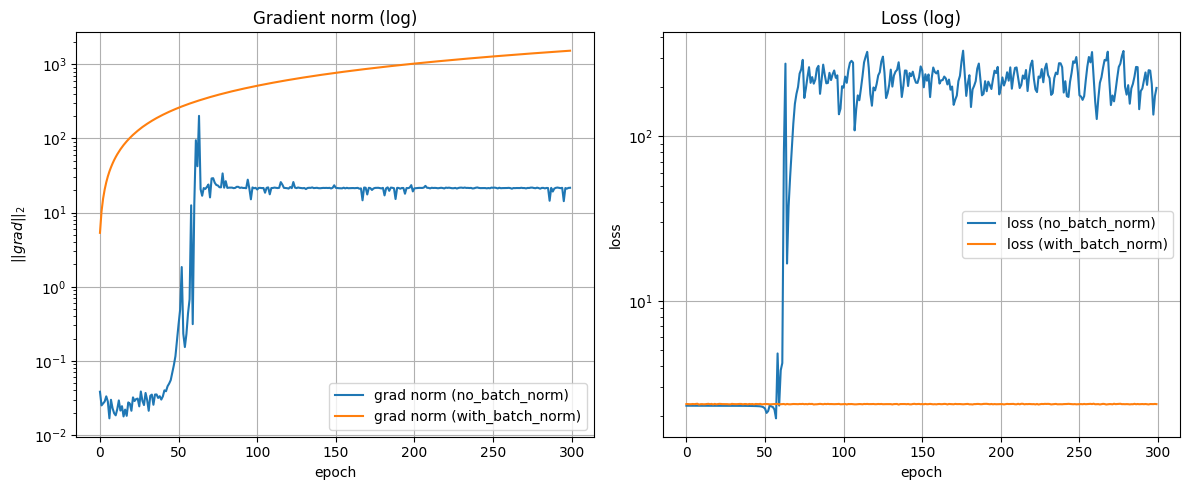

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gn_no_bn, label="grad norm (no_batch_norm)")
plt.plot(gn_with_bn, label="grad norm (with_batch_norm)")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("$||grad||_2$")
plt.title("Gradient norm (log)")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(loss_no_bn, label="loss (no_batch_norm)")
plt.plot(loss_with_bn, label="loss (with_batch_norm)")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss (log)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### Левый график:

Без BatchNorm – Сначала градиенты крошечные (почти тормозим), потом около ~55-й эпохи — резкий взрыв на несколько порядков: шаги становятся гигантскими, начинается разнос

C BatchNorm – Растёт плавно и остаётся в разумных пределах — без резких скачков и бесконечностей. Это признак стабильного обратного распространения.

##### Правый график:

Без нормализации глубокая сеть с большим LR быстро уходит в область, где активации/градиенты раздуваются → шаги оптимизатора становятся неадекватными → лосс улетает

BatchNorm выравнивает масштаб активаций в каждом слое, стабилизируя backprop. Поэтому даже при завышенном LR и большой глубине обучение остаётся управляемым

## CNN

Сверточные нейронные сети – это база, которая до сих пор с нами и никуда не денется. Если вы думаете, что трансформеры все поглотят, то вы ошибаетесь.

Сверточные сети используют в классификации/сегментации/детекции изображений, трекинге, супер-резолюшене, мед. изображении (КТ/МРТ), спутниковой съёмке, беспилотниках, AR/VR, а также для аудио и временных рядов (1D-свёртки).  

И пока что нет тенденции, что сверточные нейронные сети куда-то денутся.

### Свёрточный слой (Convolutional Layer)

Свёрточный слой – линейный оператор с **локальными связями** и **разделением весов**, который извлекает повторяющиеся паттерны из данных.

В 2D он применяет набор маленьких фильтров $K_h$ $\times K_w$, «скользя» по входу и вычисляя отклик на каждом положении.

На практике в DL это кросс-корреляция, но традиционно говорят «свёртка».

**Формы тензоров.**  
Вход: $(C_{\text{in}}, H, W)$.  
Параметры: $\mathbf{W}\in\mathbb{R}^{C_{\text{out}}\times (C_{\text{in}}/g)\times K_h\times K_w}$, $\ \mathbf{b}\in\mathbb{R}^{C_{\text{out}}}$, где $g$ — число групп.  
Выход: $(C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$.

**Размер выхода.**
$
H_{\text{out}}=\left\lfloor\frac{H+2P - D\,(K_h-1)-1}{S}+1\right\rfloor,\quad
W_{\text{out}}=\left\lfloor\frac{W+2P - D\,(K_w-1)-1}{S}+1\right\rfloor,
$
где $S$ — stride, $P$ — padding, $D$ — dilation.

**Ключевые идеи.**
- **Локальность:** нейрон «видит» только небольшой патч (рецептивное поле).  
- **Разделение весов:** один фильтр применяется ко всем позициям → меньше параметров.  
- **Эквивариантность сдвигу:** признак распознаётся независимо от места.  
- **Иерархия признаков:** от краёв/текстур к частям и целым объектам.

**Полезные варианты.**
- **Padding:** `valid` (без рамки) vs `same` (сохранение размера).  
- **Stride > 1:** понижает разрешение, может заменять pooling.  
- **Dilation:** расширяет рецептивное поле без роста параметров.  
- **Grouped / Depthwise separable:** снижают FLOPs (MobileNet, ResNeXt).  
- **1D/3D свёртки:** для сигналов и объёмов/видео.  
- **Transposed conv:** апсемплинг в декодерах/генераторах.


Более подробно:
1. [Курс по цифровой обработке сигналов ЦОС/DSP](https://github.com/hukenovs/dsp-theory/blob/master/src/dsp_theory_3_convolution.ipynb)

2. [Документация PyTorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

3. [Семинар intro-to-dl](https://github.com/xiyori/intro-to-dl-hse/blob/2024-2025/seminars/intro_to_dl/week_3/seminar_3_conv.ipynb)

4. [Хендбук Яндекса](https://education.yandex.ru/handbook/ml/article/svyortochnye-nejroseti)

5. [Объяснение 1D свертки](https://e2eml.school/convolution_one_d.html)

#### По-простому:

Свёртка – это способ «прокатить» маленькое окошко-фильтр по картинке и в каждой позиции измерить, насколько местный фрагмент похож на шаблон.

Фильтр/Ядро/Kernel – это таблица чисел. Мы умножаем пиксели под окошком на веса ядра и суммируем: получаем одно число – отклик.

Сдвигаем окно (stride), повторяем и собираем карту признаков.

Паддинг добавляет рамку, чтобы не терять информацию по краям.

Один и тот же фильтр применяется ко всем местам – разделение весов: параметров мало, а признак ловится в любом месте.

Несколько фильтров учат разные шаблоны: края, текстуры, формы.


![Пример свертки](https://media.springernature.com/lw1200/springer-static/image/art%3A10.1038%2Fs41598-025-92640-2/MediaObjects/41598_2025_92640_Fig3_HTML.png)

In [ ]:
x = torch.arange(1., 26.).view(1, 1, 5, 5)  # 1 изображение, 1 канал, 5x5
print("input shape:", x.shape)  # -> torch.Size([1, 1, 5, 5])


conv = nn.Conv2d(
    in_channels=1,   # число входных каналов
    out_channels=1,  # число выходных каналов (сколько карт признаков хотим)
    kernel_size=3,   # <-- ФИЛЬТР/Ядро: размер ядра 3x3
    stride=2,        # <-- STRIDE (ШАГ) окна свёртки
    padding=1,       # <-- PADDING (РАМКА) из нулей вокруг картинки
    bias=False
)

# conv.weight — это сами ПАРАМЕТРЫ фильтра (веса), форма: [C_out, C_in, K, K]
with torch.no_grad():
    conv.weight[:] = 1/9  * torch.ones_like(conv.weight)  # простой усредняющий 3x3

input shape: torch.Size([1, 1, 5, 5])


In [ ]:
y = conv(x)  # <-- OUTPUT: результат свёртки
print("output shape:", y.shape)
print(y)

# Формула для размеров выхода (для каждой оси H и W):
# H_out = floor((H + 2*P - D*(K-1) - 1)/S + 1)
# W_out = floor((W + 2*P - D*(K-1) - 1)/S + 1)
# Здесь: H=W=5, K=3, P=1, S=2, D=1 -> H_out=W_out=floor((5+2-3-1)/2 + 1)=3
# Итого выход: [N, C_out, 3, 3]

output shape: torch.Size([1, 1, 3, 3])
tensor([[[[ 1.7778,  3.6667,  3.1111],
          [ 7.6667, 13.0000,  9.6667],
          [ 8.4444, 13.6667,  9.7778]]]], grad_fn=<ConvolutionBackward0>)


#### Pooling

Пулинг (pooling) – это понижение пространственного разрешения карты признаков с помощью скользящего окна и сводной операции.

Нужен он для того, чтобы уменьшить размер тензоров и вычисления, расширить эффективное рецептивное поле последующих слоёв и добавить устойчивость к небольшим сдвигам/деформациям.

Max pooling берёт максимум в окне (чаще 2×2, stride 2). Хорошо ловит «наличие» признака, подчёркивает края/текстуры.

Average pooling усредняет значения – сглаживает шум, но может «размывать» детали.

![Картинка_пулингов](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.researchgate.net%2Fpublication%2F340255272%2Ffigure%2Ffig4%2FAS%3A962413440557072%401606468653279%2FVisual-representation-of-pooling-operations-a-max-pooling-b-average-pooling.png&f=1&nofb=1&ipt=16dfda5bcb7c695ad7e18083764bfa3cf1616b422b42066b2b42290903a38e27)

In [23]:
# Пусть у нас на вход: [N, C, H, W] = [1, 1, 4, 4]

x = torch.tensor([[[
    [1.,  2.,  3.,  4.],
    [5.,  6.,  7.,  8.],
    [9., 10., 11., 12.],
    [13., 14., 15., 16.]
]]])

pool = nn.MaxPool2d(
    kernel_size=2,  # <-- фильтр 2x2
    stride=2,       # <-- шаг (страйд)
    padding=0       # <-- паддинг
)

y = pool(x)        # OUTPUT: [1, 1, 2, 2], значения максимумов по окнам
print(y)

tensor([[[[ 6.,  8.],
          [14., 16.]]]])


### LeNet

Начнем наш рассказ с [LeNet](https://leon.bottou.org/publications/pdf/ieee-1998.pdf)

LeNet – классическая свёрточная нейросеть (Яна ЛеКуна)[https://scholar.google.com/citations?user=WLN3QrAAAAAJ&hl=en] и соавторов (1998), один из первых убедительных примеров, что нейросети могут энд-ту-энд учиться распознавать образы напрямую с пикселей, без «ручных» признаков.

Модель создавалась в AT&T Bell Labs и применялась для распознавания рукописных цифр на банковских чеках и почтовых индексах; позднее стала учебным стандартом на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database).

![Пример из MNIST](https://upload.wikimedia.org/wikipedia/commons/b/b1/MNIST_dataset_example.png)

![Пример реального текста](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/NIST_SD-19_f1002_33.png/960px-NIST_SD-19_f1002_33.png)

Давайте взглянем на архитектуру:

![Пример реального текста](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/LeNet-5_architecture.svg/1599px-LeNet-5_architecture.svg.png)

Вход – это изображение 32×32 в оттенках серого (рукописные цифры 28×28 обычно дополняются до 32×32 с помощью padding операции).

Сеть строит иерархию признаков через локальные рецептивные поля и разделение весов:

*C1*: свёртка 5×5, 6 карт признаков → 28×28.

*S2*: пулинг (среднее/avg-pool с обучаемым масштабом и сдвигом) → 14×14.

*C3*: свёртка 5×5, 16 карт → 10×10 (неполные связи между картами для разнообразия признаков).

*S4*: пулинг → 5×5.

*C5*: свёртка 5×5 с 120 каналами, дающая по сути 1×1 на канал (глобальная свёртка).

*F6*: полносвязный слой на 84 нейрона. Выход: 10 узлов (классы цифр).


В оригинале использовались сигмоидальные/гиперболические активации (tanh), softmax — в более поздних релизах.

Ключевые идеи, сделавшие LeNet важной:

- Локальность и разделение весов (один фильтр «скользит» по всему полю) резко уменьшают число параметров, повышая обобщение.

- Иерархия признаков: ранние слои учат края и текстуры, средние – простые формы, поздние – шаблоны цифр.

- Инвариантность к малым сдвигам достигается за счёт пулинга.

- Полный градиентный энд-ту-энд тренинг c помощью backprop на больших потоках реальных данных

#### Давайте реализуем на LeNet на PyTorch

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10, use_relu_maxpool=False):
        super().__init__()
        # C1: 1->6, 5x5, out 28x28
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=True) ### YOUR CODE:
        # S2: avg pool 2x2 -> 14x14
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) if not use_relu_maxpool else nn.MaxPool2d(2,2) ### YOUR CODE:

        # C3: 6->16, 5x5, out 10x10 (в оригинале частичные связи; здесь — полные)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0, bias=True) ### YOUR CODE:
        # S4: avg pool 2x2 -> 5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) if not use_relu_maxpool else nn.MaxPool2d(2,2) ### YOUR CODE:

        # C5: 16->120, 5x5, out 1x1
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0, bias=True) ### YOUR CODE:

        # F6: 120 -> 84
        self.fc1 = nn.Linear(120, 84, bias=True) ### YOUR CODE:
        # Output: 84 -> num_classes
        self.fc2 = nn.Linear(84, num_classes, bias=True) ### YOUR CODE:

        self.use_relu_maxpool = use_relu_maxpool

    def forward(self, x):
        # C1 -> Tanh/ReLU -> S2
        x = self.conv1(x) ### YOUR CODE:
        x = F.relu(x) if self.use_relu_maxpool else torch.tanh(x) ### YOUR CODE:
        x = self.pool1(x) ### YOUR CODE:

        # C3 -> Tanh/ReLU -> S4
        x = self.conv2(x) ### YOUR CODE:
        x = F.relu(x) if self.use_relu_maxpool else torch.tanh(x) ### YOUR CODE:
        x = self.pool2(x) ### YOUR CODE:

        # C5 -> Tanh/ReLU
        x = self.conv3(x) ### YOUR CODE:
        x = F.relu(x) if self.use_relu_maxpool else torch.tanh(x) ### YOUR CODE:

        # F6 -> Tanh/ReLU -> Out
        x = x.view(x.size(0), -1)  # (N,120) ### YOUR CODE:
        x = self.fc1(x) ### YOUR CODE:
        x = F.relu(x) if self.use_relu_maxpool else torch.tanh(x) ### YOUR CODE:
        logits = self.fc2(x) ### YOUR CODE:
        return logits

In [ ]:
transform = transforms.Compose([
    transforms.Pad(2),          # 28x28 -> 32x32
    transforms.ToTensor(),
    # Нормализация не обязательна для демонстрации; можно включить для чуть лучшей сходимости:
    # transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=1024, shuffle=False)

len(train_ds), len(test_ds)

(60000, 10000)

In [ ]:
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            total_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            total_correct += (pred == y).sum().item()
            total += x.size(0)
    return total_loss / total, total_correct / total

def train_lenet(model, optimizer, train_loader, test_loader, epochs=5, loss_fn=nn.CrossEntropyLoss()):
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    for epoch in range(1, epochs+1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for x_train, y_train in pbar:
            x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            logits = model(x_train)
            loss = loss_fn(logits, y_train)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        train_loss, train_acc = evaluate(model, train_loader, loss_fn)
        test_loss, test_acc = evaluate(model, test_loader,  loss_fn)
        print(f"[{epoch:02d}] train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"test: loss={test_loss:.4f}, acc={test_acc:.4f}")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
    return train_losses, train_accs, test_losses, test_accs

In [ ]:
model_lenet = LeNet5(num_classes=10, use_relu_maxpool=False).to(device) ### Историческая версия, как прям было в оригинале
# model_modern_lenet = LeNet5(num_classes=10, use_relu_maxpool=True).to(device) ### По-современнее версия, с добавлением maxpool и с ReLU
# Подсчёт числа параметров
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print("Params (LeNet classic):", count_params(model_lenet))
optimizer = torch.optim.SGD(model_lenet.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


Params (LeNet classic): 61706


In [ ]:
train_losses, train_accs, test_losses, test_accs = train_lenet(model_lenet, optimizer, train_loader, test_loader, epochs=10)

[01] train: loss=2.2229, acc=0.4030 | test: loss=2.2204, acc=0.4188


[02] train: loss=1.1779, acc=0.6957 | test: loss=1.1583, acc=0.7017


[03] train: loss=0.5909, acc=0.8336 | test: loss=0.5749, acc=0.8420


[04] train: loss=0.4477, acc=0.8713 | test: loss=0.4312, acc=0.8761


[05] train: loss=0.3780, acc=0.8914 | test: loss=0.3622, acc=0.8952


[06] train: loss=0.3346, acc=0.9012 | test: loss=0.3190, acc=0.9060


[07] train: loss=0.3018, acc=0.9111 | test: loss=0.2875, acc=0.9159


[08] train: loss=0.2751, acc=0.9185 | test: loss=0.2619, acc=0.9247


[09] train: loss=0.2526, acc=0.9250 | test: loss=0.2403, acc=0.9289


[10] train: loss=0.2328, acc=0.9308 | test: loss=0.2219, acc=0.9352


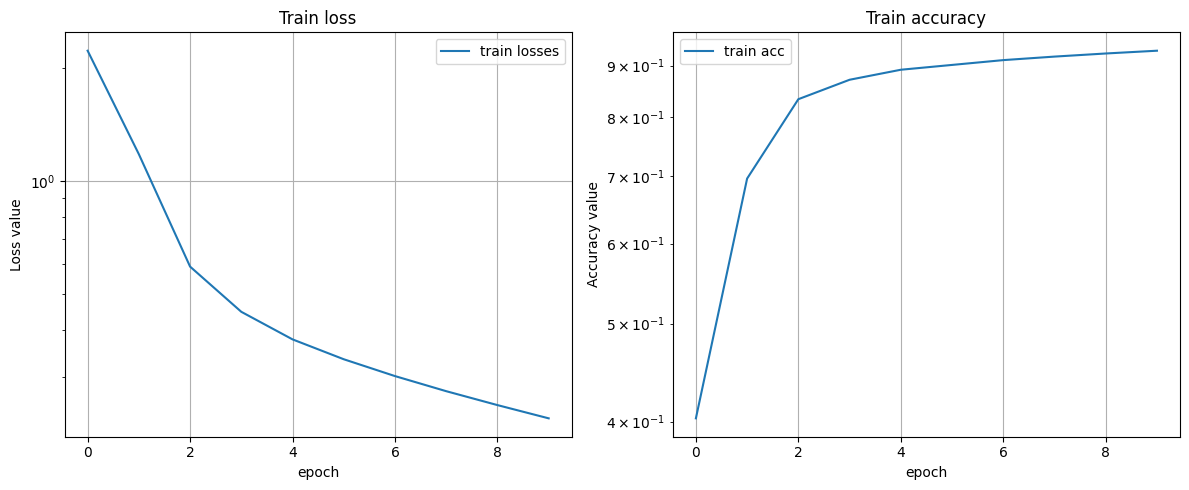

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="train losses")

plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("Loss value")
plt.title("Train loss")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(train_accs, label="train acc")

plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("Accuracy value")
plt.title("Train accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

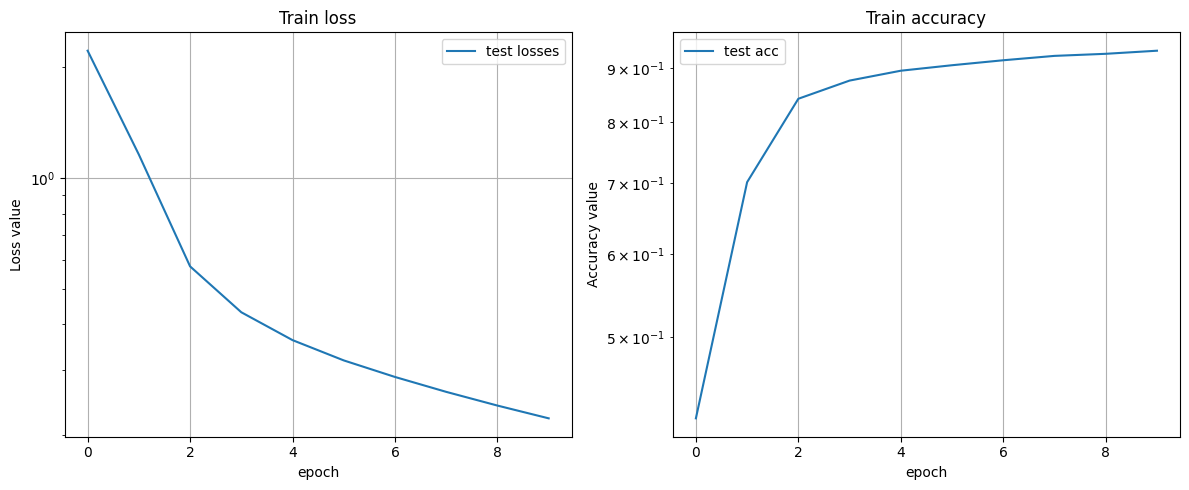

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(test_losses, label="test losses")

plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("Loss value")
plt.title("Train loss")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(test_accs, label="test acc")

plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("Accuracy value")
plt.title("Train accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

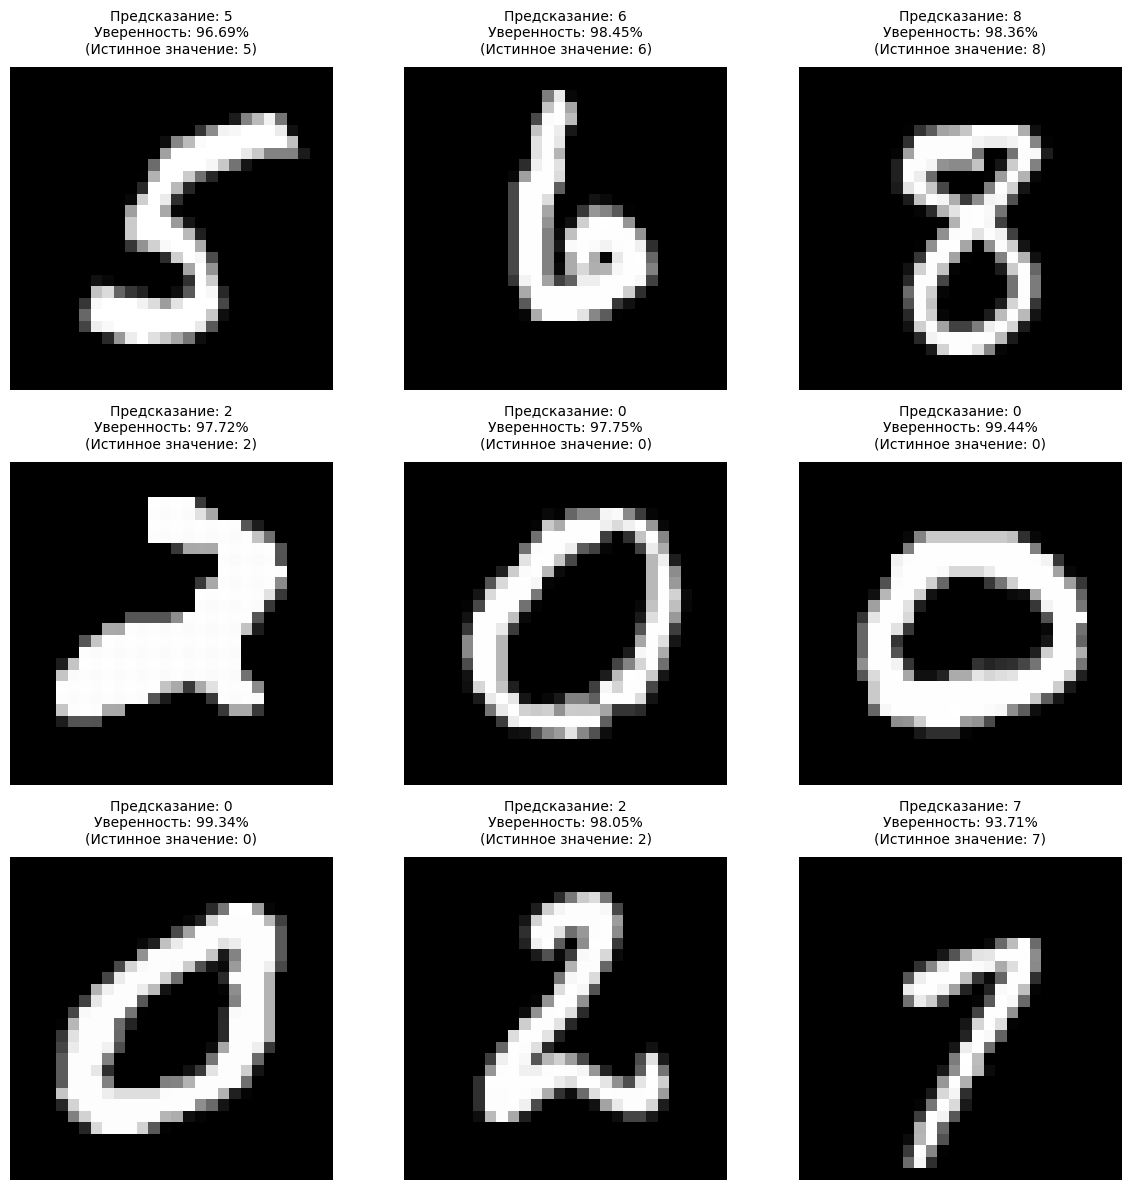

In [ ]:
def visualize_predictions(model, dataset, device='cpu', num_images=9):
    """
    Визуализирует предсказания модели на случайных изображениях
    """
    model.eval()

    # Выбираем 9 случайных индексов
    indices = random.sample(range(len(dataset)), num_images)

    # Создаем subplot 3x3
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()  # Преобразуем в 1D массив для удобства

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Получаем изображение и истинную метку
            image, true_label = dataset[idx]

            # Подготавливаем изображение для модели
            image_batch = image.unsqueeze(0).to(device)  # Добавляем batch dimension

            # Получаем предсказание
            logits = model(image_batch)
            probabilities = F.softmax(logits, dim=1)

            # Находим предсказанный класс и уверенность
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = torch.max(probabilities).item()

            # Отображаем изображение
            # Убираем padding для визуализации (возвращаем к 28x28)
            image_np = image.squeeze().numpy()
            if image_np.shape == (32, 32):  # Если есть padding
                image_np = image_np[2:30, 2:30]  # Обрезаем padding

            axes[i].imshow(image_np, cmap='gray')
            axes[i].axis('off')

            # Создаем заголовок с предсказанием и уверенностью
            title = f'Предсказание: {predicted_class}\nУверенность: {confidence:.2%}\n(Истинное значение: {true_label})'
            axes[i].set_title(title, fontsize=10, pad=10)

    plt.tight_layout()
    plt.show()

visualize_predictions(model_lenet, test_ds, device, num_images=9)

### Residual / Skip Connection

**Определение.** Остаточное соединение добавляет вход $x$ к выходу подслоя $F(x)$:

$
y = F(x) + x
$Ё

**Интуиция.** Блок учит остаток $F(x)=H(x)-x$, а не полную функцию $H(x)$.

Это даёт «прямой путь» для сигналов и градиентов, уменьшает затухание/взрыв и устраняет деградацию при увеличении глубины.

Если по простому, то градиент не застревает в глубоких слоях и суммируется после.

Такой прямой путь даёт градиентам короткую дорогу назад, поэтому они не исчезают и не взрываются.

![Skip-connection](https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.lin1 = nn.Linear(dim, dim)
        self.lin2 = nn.Linear(dim, dim)

    def forward(self, x):
        F_x = self.lin2(F.relu(self.lin1(x)))  # «поправка» F(x)
        y = F.relu(F_x + x)                    # skip-connection и ReLU
        return y


# Очень простая сеть: вход -> проекция -> residual-блок -> голова
class TinyResMLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super().__init__()
        self.inp = nn.Linear(d_in, d_hidden)   # проекция в скрытое пространство
        self.block = ResidualBlock(d_hidden)   # один residual-блок
        self.head = nn.Linear(d_hidden, d_out) # выходные логиты/значения

    def forward(self, x):
        x = F.relu(self.inp(x))
        x = self.block(x)
        return self.head(x)

### ResNet

ResNet (Residual Network) – семейство свёрточных сетей с остаточными связями (skip-connections), предложенное [He et al](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) на конференции CVPR’16.

#### Блоки и линейки

- **BasicBlock (ResNet-18/34)** – два `3×3` conv. Лёгкий и быстрый.
- **Bottleneck (ResNet-50/101/152)** – `1×1 → 3×3 → 1×1`: первый `1×1` сжимает каналы, последний расширяет (обычно коэффициент ×4). Дает глубокие сети при умеренных FLOPs.
- Если меняются пространственные размеры/число каналов, **shortcut** делают проекцией `1×1` со `stride > 1`.

#### Почему ResNet — стандартный бэкбон

- Легко масштабируется по глубине/ширине и переносится между задачами.
- Совместим с детекцией/сегментацией: **FPN** строит пирамиду по выходам стейджей (C2–C5).
- Отличный компромисс «качество/стоимость»:  
  **ResNet-18** – мобайл/edge, **ResNet-50** – «рабочая лошадка», **ResNet-101/152** – максимум точности.

In [3]:
class ResidualBlock(nn.Module):
    """
    Простой residual блок: x -> conv -> relu -> conv -> + x -> relu
    """
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        # Сохраняем оригинальный вход (это и есть residual connection!)
        residual = x

        # Основной путь
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Добавляем residual connection: F(x) + x
        out = out + residual  # ← ЭТО ГЛАВНОЕ!

        # Финальная активация
        out = F.relu(out)

        return out


class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10, num_blocks=3):
        super().__init__()

        # Начальная обработка: 1 -> 64 каналов
        self.initial_conv = nn.Conv2d(1, 64, kernel_size=7, padding=3, bias=False)
        self.initial_bn = nn.BatchNorm2d(64)

        # Residual блоки
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(64) for _ in range(num_blocks)
        ])

        # Глобальный average pooling + классификатор
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # Начальная обработка
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = F.relu(x)

        # Проходим через residual блоки
        for block in self.residual_blocks:
            x = block(x)  # Здесь происходит F(x) + x

        # Финальная классификация
        x = self.global_pool(x)  # (N, 64, 1, 1)
        x = x.view(x.size(0), -1)  # (N, 64)
        x = self.classifier(x)

        return x

Ничего обучать не будем. В домашке будете реализовывать ResNet 18/34/50.

### Fine-tuning

Дообучение (fine-tuning) – это процесс адаптации уже предварительно обученной нейронной сети для решения новой, специфической задачи.

Представьте, что у вас есть модель, которая уже научилась распознавать общие признаки изображений на миллионах фотографий.

Вместо того чтобы обучать новую сеть с нуля для распознавания, скажем, пород собак, вы берете эту готовую модель и "доучиваете" её на меньшем наборе данных с собаками.
Дообучение работает благодаря тому, что нижние слои нейронной сети изучают базовые признаки (края, текстуры, простые формы), которые универсальны для многих задач.

Верхние слои специализируются на конкретной задаче. При дообучении мы можем либо обучать всю сеть на новых данных с очень малой скоростью обучения, либо заморозить часть весов и обучать только верхние слои.

Преимущества дообучения очевидны: значительно меньше времени и вычислительных ресурсов, меньше данных для обучения, и часто лучшее качество результата, особенно когда у вас ограниченный набор данных.

Давайте возьмем предобученную ResNet50 (обученную на ImageNet) и адаптируем её для классификации пород собак. 

Модель уже знает базовые визуальные признаки, нам нужно только научить её различать породы.

Нам надо заменить стандартную голову ResNet (1000 классов ImageNet) на новую голову с 37 выходами для наших пород собак.

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  # ImageNet нормализация
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.OxfordIIITPet(
    root='./data',
    split='trainval',
    target_types='category',
    download=True,
    transform=train_transforms
)

test_dataset = datasets.OxfordIIITPet(
    root='./data',
    split='test',
    target_types='category',
    download=True,
    transform=val_transforms
)

In [5]:
batch_size = 1024
num_classes = len(train_dataset.classes)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
print(f"Сколько пород собак (классов): {len(train_dataset.classes)}")
print(f"Длина train выборки: {len(train_dataset)}")
print(f"Длина test выборки: {len(test_dataset)}")

Сколько пород собак (классов): 37
Длина train выборки: 3680
Длина test выборки: 3669


In [7]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler,
                device, num_epochs, train_dataset_size, test_dataset_size):
    """
    Функция обучения модели с прогресс-барами и визуализацией

    Args:
        model: PyTorch модель
        train_loader: DataLoader для обучающих данных
        test_loader: DataLoader для валидационных данных
        criterion: функция потерь
        optimizer: оптимизатор
        scheduler: планировщик скорости обучения
        device: устройство (cpu/cuda)
        num_epochs: количество эпох
        train_dataset_size: размер обучающего датасета
        test_dataset_size: размер валидационного датасета

    Returns:
        dict: история обучения с потерями и точностью
    """

    # Инициализация истории обучения
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'\nЭпоха {epoch+1}/{num_epochs}')
        print('-' * 50)

        # === ФАЗА ОБУЧЕНИЯ ===
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Прогресс-бар для обучения
        train_pbar = tqdm(train_loader, desc=f'Обучение эпоха {epoch+1}',
                         leave=False, dynamic_ncols=True)

        for inputs, labels in train_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            # Статистика
            batch_loss = loss.item() * inputs.size(0)
            batch_corrects = torch.sum(preds == labels.data)

            running_loss += batch_loss
            running_corrects += batch_corrects

            # Обновляем прогресс-бар
            current_acc = batch_corrects.double() / inputs.size(0)
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{current_acc:.4f}'
            })

        # Средние метрики за эпоху обучения
        epoch_train_loss = running_loss / train_dataset_size
        epoch_train_acc = running_corrects.double() / train_dataset_size

        # === ФАЗА ВАЛИДАЦИИ ===
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        val_pbar = tqdm(test_loader, desc=f'Валидация эпоха {epoch+1}',
                       leave=False, dynamic_ncols=True)

        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                batch_loss = loss.item() * inputs.size(0)
                batch_corrects = torch.sum(preds == labels.data)

                val_running_loss += batch_loss
                val_running_corrects += batch_corrects

                # Обновляем прогресс-бар
                current_acc = batch_corrects.double() / inputs.size(0)
                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{current_acc:.4f}'
                })

        # Средние метрики за эпоху валидации
        epoch_val_loss = val_running_loss / test_dataset_size
        epoch_val_acc = val_running_corrects.double() / test_dataset_size

        # Сохраняем историю
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        # Выводим результаты эпохи
        print(f'Обучение   - Потери: {epoch_train_loss:.4f} Точность: {epoch_train_acc:.4f}')
        print(f'Валидация  - Потери: {epoch_val_loss:.4f} Точность: {epoch_val_acc:.4f}')
        print(f'LR: {scheduler.get_last_lr()[0]:.2e}')

        # Обновляем планировщик
        scheduler.step()

    return history

#### Шаг 1. Загрузка ResNet18

In [8]:
model = models.resnet18(weights='IMAGENET1K_V1')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Шаг 2. Заменяем голову на свою.

In [9]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))

In [10]:
# Давайте еще раз посмотрим на нашу модель
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Шаг 3. Дообучение

Важно подметить, что для дообучения мы используем 

In [11]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
history_finetune = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=10,
    train_dataset_size=len(train_dataset),
    test_dataset_size=len(test_dataset)
)



Эпоха 1/10
--------------------------------------------------


Обучение   - Потери: 3.4961 Точность: 0.0872
Валидация  - Потери: 3.0040 Точность: 0.2559
LR: 1.00e-04

Эпоха 2/10
--------------------------------------------------


Обучение   - Потери: 2.7094 Точность: 0.4269
Валидация  - Потери: 2.3123 Точность: 0.5211
LR: 1.00e-04

Эпоха 3/10
--------------------------------------------------


Обучение   - Потери: 2.0915 Точность: 0.6647
Валидация  - Потери: 1.6666 Точность: 0.6800
LR: 1.00e-04

Эпоха 4/10
--------------------------------------------------


Обучение   - Потери: 1.6159 Точность: 0.7845
Валидация  - Потери: 1.2103 Точность: 0.7607
LR: 1.00e-04

Эпоха 5/10
--------------------------------------------------


Обучение   - Потери: 1.2782 Точность: 0.8378
Валидация  - Потери: 0.9673 Точность: 0.8043
LR: 1.00e-04

Эпоха 6/10
--------------------------------------------------


Обучение   - Потери: 1.0238 Точность: 0.8674
Валидация  - Потери: 0.8714 Точность: 0.8267
LR: 1.00e-04

Эпоха 7/10
--------------------------------------------------


Обучение   - Потери: 0.8299 Точность: 0.8948
Валидация  - Потери: 0.8366 Точность: 0.8277
LR: 1.00e-04

Эпоха 8/10
--------------------------------------------------


Обучение   - Потери: 0.7168 Точность: 0.9087
Валидация  - Потери: 0.8564 Точность: 0.8313
LR: 1.00e-05

Эпоха 9/10
--------------------------------------------------


Обучение   - Потери: 0.7012 Точность: 0.9122
Валидация  - Потери: 0.8709 Точность: 0.8332
LR: 1.00e-05

Эпоха 10/10
--------------------------------------------------


Обучение   - Потери: 0.6856 Точность: 0.9133
Валидация  - Потери: 0.8790 Точность: 0.8351
LR: 1.00e-05


In [13]:
torch.save(model.state_dict(), 'model_weights.pth')

print("Model weights saved successfully!")

Model weights saved successfully!


### Заморозка весов

Заморозка весов (weight freezing) – это техника, при которой параметры определенных слоев нейронной сети фиксируются и не обновляются во время обучения.
Замороженные веса остаются неизменными, в то время как остальная часть сети продолжает обучаться.

Эта техника особенно полезна при дообучении. Например, если вы используете предобученную модель ResNet для классификации медицинских изображений, вы можете заморозить веса нижних слоев (которые распознают базовые визуальные признаки) и обучать только верхние слои, специфичные для медицинской диагностики.

Заморозка весов помогает предотвратить "катастрофическое забывание" – ситуацию, когда сеть теряет ранее изученные полезные представления при обучении на новой задаче. Также это ускоряет обучение и снижает требования к памяти, поскольку градиенты вычисляются только для незамороженных слоев.

#### Шаг 1. Загружаем модель

In [14]:
freeze_model = models.resnet18(weights='IMAGENET1K_V1')
print("Загружена предобученная ResNet18")

Загружена предобученная ResNet18


#### Шаг 2. Замораживаем backbone.

In [16]:
print("Замораживаем веса бекбона...")
for param in freeze_model.parameters():
    param.requires_grad = False
print("Веса backbone заморожены")

Замораживаем веса бекбона...
Веса backbone заморожены


#### Шаг 3. Также заменяем предобученную голову на свою

In [17]:
num_features = freeze_model.fc.in_features
freeze_model.fc = nn.Linear(num_features, len(train_dataset.classes))

#### Шаг 4. Обучение только головы

In [19]:
freeze_model = freeze_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(freeze_model.parameters(), lr=1e-3) # Важно обратить внимание! Когда мы дообучаем веса, то LR должен быть маленьким, чтобы не вылететь из локального минимума
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
history_freeze = train_model(
    model=freeze_model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=10,
    train_dataset_size=len(train_dataset),
    test_dataset_size=len(test_dataset)
)


Эпоха 1/10
--------------------------------------------------


Обучение   - Потери: 3.6315 Точность: 0.0552
Валидация  - Потери: 3.2410 Точность: 0.1436
LR: 1.00e-03

Эпоха 2/10
--------------------------------------------------


Обучение   - Потери: 3.1400 Точность: 0.2071
Валидация  - Потери: 2.7940 Точность: 0.3838
LR: 1.00e-03

Эпоха 3/10
--------------------------------------------------


Обучение   - Потери: 2.7032 Точность: 0.4408
Валидация  - Потери: 2.3982 Точность: 0.5669
LR: 1.00e-03

Эпоха 4/10
--------------------------------------------------


Обучение   - Потери: 2.3122 Точность: 0.6057
Валидация  - Потери: 2.0736 Точность: 0.6560
LR: 1.00e-03

Эпоха 5/10
--------------------------------------------------


Обучение   - Потери: 1.9843 Точность: 0.6848
Валидация  - Потери: 1.7988 Точность: 0.7171
LR: 1.00e-03

Эпоха 6/10
--------------------------------------------------


Обучение   - Потери: 1.7091 Точность: 0.7378
Валидация  - Потери: 1.5779 Точность: 0.7479
LR: 1.00e-03

Эпоха 7/10
--------------------------------------------------


Обучение   - Потери: 1.4786 Точность: 0.7753
Валидация  - Потери: 1.3991 Точность: 0.7768
LR: 1.00e-03

Эпоха 8/10
--------------------------------------------------


Обучение   - Потери: 1.3387 Точность: 0.8141
Валидация  - Потери: 1.3890 Точность: 0.7773
LR: 1.00e-04

Эпоха 9/10
--------------------------------------------------


Обучение   - Потери: 1.3241 Точность: 0.8103
Валидация  - Потери: 1.3767 Точность: 0.7795
LR: 1.00e-04

Эпоха 10/10
--------------------------------------------------


Обучение   - Потери: 1.3097 Точность: 0.8185
Валидация  - Потери: 1.3637 Точность: 0.7825
LR: 1.00e-04


In [22]:
torch.save(model.state_dict(), 'model_freeze.pth')

print("Model weights saved successfully!")

Model weights saved successfully!


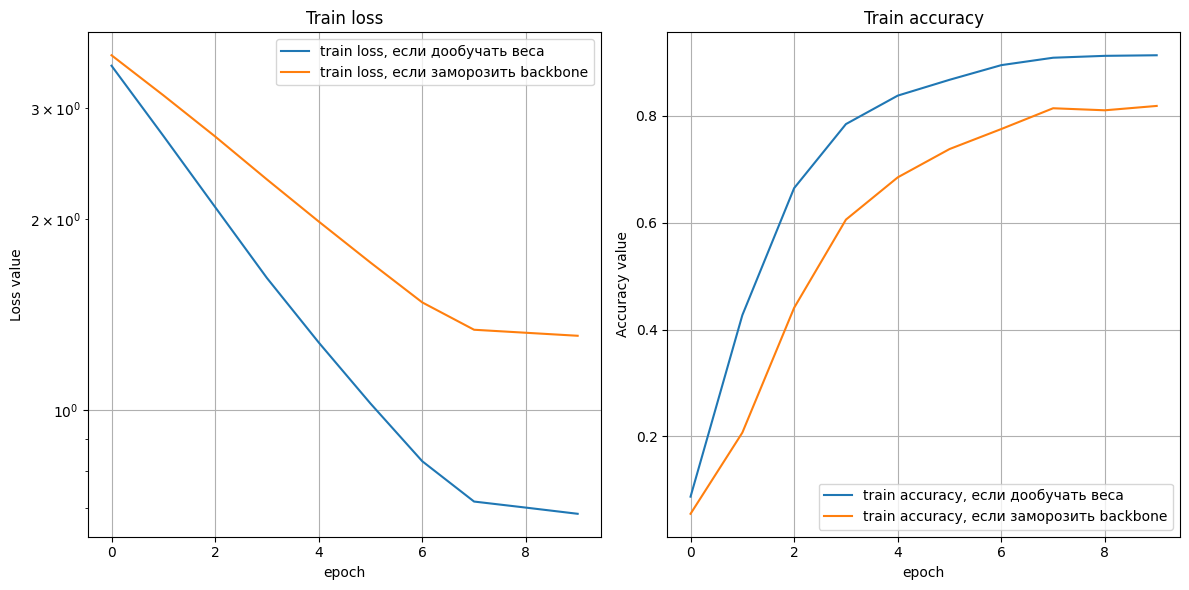

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_finetune['train_loss'], label="train loss, если дообучать веса")
plt.plot(history_freeze['train_loss'], label="train loss, если заморозить backbone")

plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("Loss value")
plt.title("Train loss")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history_finetune['train_acc'], label="train accuracy, если дообучать веса")
plt.plot(history_freeze['train_acc'], label="train accuracy, если заморозить backbone")

plt.xlabel("epoch")
plt.ylabel("Accuracy value")
plt.title("Train accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

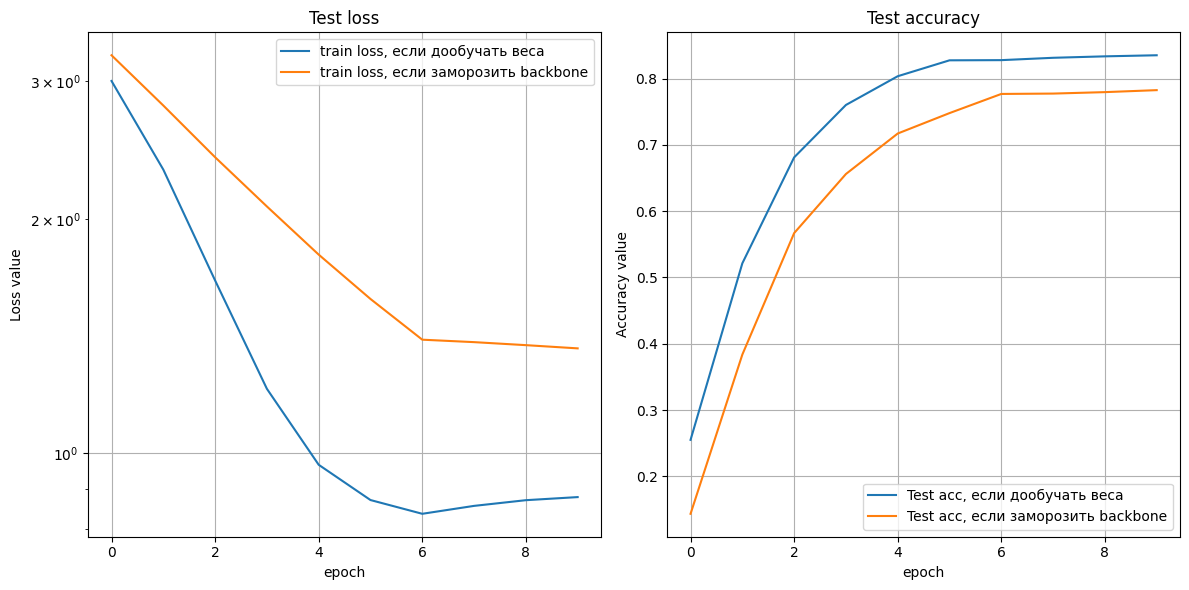

In [28]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_finetune['val_loss'], label="train loss, если дообучать веса")
plt.plot(history_freeze['val_loss'], label="train loss, если заморозить backbone")

plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("Loss value")
plt.title("Test loss")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history_finetune['val_acc'], label="Test acc, если дообучать веса")
plt.plot(history_freeze['val_acc'], label="Test acc, если заморозить backbone")

plt.xlabel("epoch")
plt.ylabel("Accuracy value")
plt.title("Test accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Разные ситуации требуют разных решений. Если у нас мало GPU memory и не хочется тратить много своих ресурсов, то стоит рассмотреть заморозку backbone и обучать только классификационную голову.

Но в реальности, уже мало кто замораживает backbone, все сейчас фантюнят модели. Например SFT в LLMках.

### Визуализация

In [27]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denormalize_batch(x):
    # x: (B,3,H,W), torch.Tensor on CPU/GPU
    return (x * IMAGENET_STD.to(x.device) + IMAGENET_MEAN.to(x.device)).clamp(0,1)


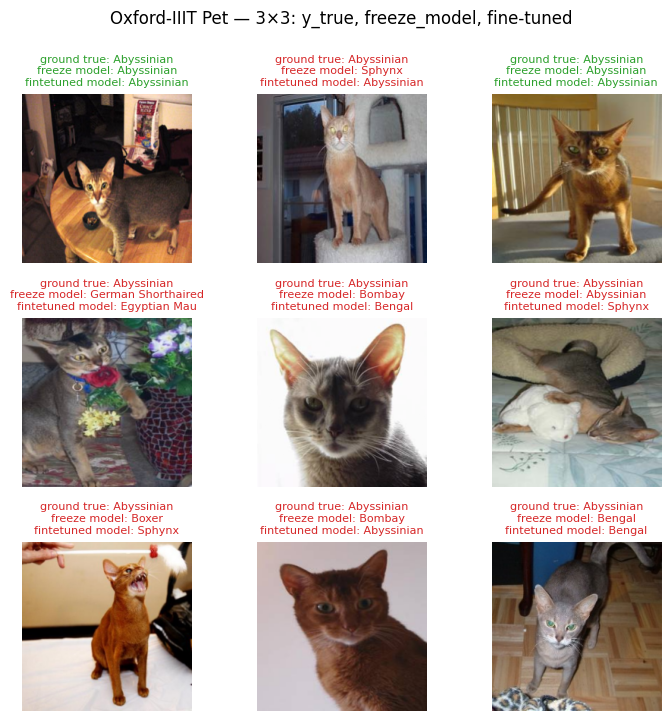

In [35]:
@torch.no_grad()
def visualize_grid(freeze_model, model, data_loader, device):
    freeze_model.eval().to(device)
    model.eval().to(device)

    # берём один большой батч
    images, targets = next(iter(data_loader))
    images  = images.to(device)
    targets = targets.to(device)

    # ограничимся 81 образцом
    show_n = min(81, images.size(0))
    images  = images[:show_n]
    targets = targets[:show_n]

    # предсказания двух моделей
    logits_freeze = freeze_model(images)
    logits_model  = model(images)
    preds_freeze  = logits_freeze.argmax(1)
    preds_model   = logits_model.argmax(1)

    # денорм для отображения (на CPU)
    imgs_vis = denormalize_batch(images).cpu().numpy()

    rows = cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(2.4*cols, 2.4*rows))
    axes = np.array(axes).reshape(rows, cols)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        if i < show_n:
            img = np.transpose(imgs_vis[i], (1, 2, 0))
            ax.imshow(img)
            ax.axis("off")

            y = targets[i].item()
            p1 = preds_freeze[i].item()
            p2 = preds_model[i].item()
            y_name  = test_dataset.classes[y]
            p1_name = test_dataset.classes[p1]
            p2_name = test_dataset.classes[p2]

            both_ok = (p1 == y) and (p2 == y)
            color = "tab:green" if both_ok else "tab:red"

            ax.set_title(
                f"ground true: {y_name}\n"
                f"freeze model: {p1_name}\n"
                f"fintetuned model: {p2_name}",
                fontsize=8, color=color
            )
        else:
            ax.axis("off")

    fig.suptitle("Oxford-IIIT Pet — 3×3: y_true, freeze_model, fine-tuned", y=0.995)
    plt.tight_layout()
    plt.show()


visualize_grid(freeze_model, model, test_loader, device)